In [ ]:
!pip install git+https://github.com/ai-forever/diffusers.git
!git clone https://github.com/lllyasviel/ControlNet
!pip install einops
!pip install timm
!pip install transformers
!pip install basicsr
!pip install accelerate

  Cloning https://github.com/ai-forever/diffusers.git to /tmp/pip-req-build-2ls69ej4
  Running command git clone --filter=blob:none --quiet https://github.com/ai-forever/diffusers.git /tmp/pip-req-build-2ls69ej4
  Resolved https://github.com/ai-forever/diffusers.git to commit 8e6134d57fa35b80679580ee8b1c9a25aa143a6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 9.0 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.18.0.dev0-py3-none-any.whl size=1165361 sha256=49f45ff2f62a8f80728ea1e18eb718c781ddba4d1cae4693bd857da3e19ab67a
  Stored in directory: /tmp/pip-ephem-wheel-cache-qy1hm93i/wheels/1e/76/3d/f2637ece4e8ae3f6f07a4eee8c13505ce927d1aedd919fad64
Successfully built diffusers
Cloning into 'ControlNet'...
remote: Enumerating objects: 1350, done.
remote: Counting objects: 100% (435/435), done.
remote: Compressing objects: 

In [ ]:
import torch
torch.__version__

'2.0.1+cu118'

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import sys
sys.path.append('/content/ControlNet/')
from annotator.util import resize_image, HWC3
from annotator.midas import MidasDetector
from diffusers import Kandinsky2_2PriorEmb2EmbPipeline
from diffusers import Kandinsky2_2_DecoderControlnetImg2ImgPipeline
import torch
import PIL
import torch
from diffusers.utils import load_image
from torchvision import transforms
from transformers import CLIPVisionModelWithProjection
from diffusers.models import UNet2DConditionModel
import numpy as np

In [ ]:
def make_hint(img, detector):
    input_image = np.array(img)
    img = resize_image(HWC3(input_image), input_image.shape[1])
    H, W, C = img.shape
    detected_map, _ = detector(img)
    detected_map = HWC3(detected_map)
    detected_map = torch.from_numpy(detected_map.copy()).float() / 255.0
    hint = detected_map.permute(2, 0, 1)
    return hint

In [ ]:
image_encoder = CLIPVisionModelWithProjection.from_pretrained('kandinsky-community/kandinsky-2-2-prior', subfolder='image_encoder').to(torch.float16).to('cuda')

In [ ]:
unet = UNet2DConditionModel.from_pretrained('kandinsky-community/kandinsky-2-2-controlnet-depth', subfolder='unet').to(torch.float16).to('cuda')

In [ ]:
detector = MidasDetector()

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


In [ ]:
prior = Kandinsky2_2PriorEmb2EmbPipeline.from_pretrained('kandinsky-community/kandinsky-2-2-prior', image_encoder=image_encoder, torch_dtype=torch.float16)
prior = prior.to("cuda")

text_encoder/model.safetensors not found


In [ ]:
decoder = Kandinsky2_2_DecoderControlnetImg2ImgPipeline.from_pretrained('kandinsky-community/kandinsky-2-2-controlnet-depth', unet=unet, torch_dtype=torch.float16)
decoder = decoder.to("cuda")

vae/diffusion_pytorch_model.safetensors not found


In [ ]:
img = load_image(
             "https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main"
            "/kandinsky/cat.png"
        ).resize((512, 512))

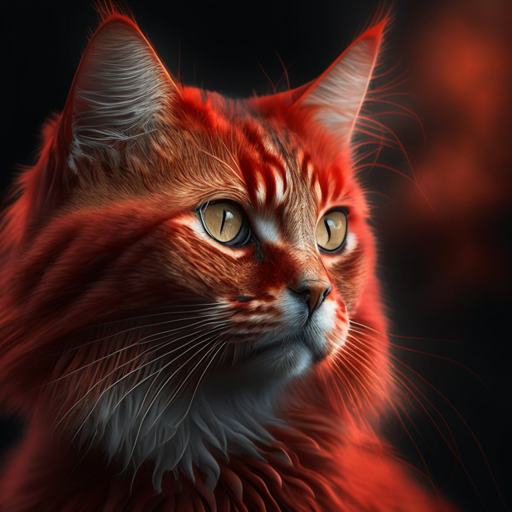

In [ ]:
img

In [ ]:
negative_prior_prompt ='lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature'
torch.manual_seed(42)
clip_img_emb = prior.interpolate(images_and_prompts=[img], weights=[1], num_images_per_prompt=1, ).image_embeds
img_emb = prior(prompt='A robot, 4k photo', emb=clip_img_emb, strength=0.85, num_inference_steps=25, num_images_per_prompt=1,)
negative_emb = prior(prompt=negative_prior_prompt, emb=clip_img_emb, strength=1, num_inference_steps=25, num_images_per_prompt=1)
hint = make_hint(img, detector).unsqueeze(0).half().to('cuda').repeat(2, 1, 1, 1)
images = decoder(image=img, strength=0.5, image_embeds=img_emb.image_embeds, negative_image_embeds=negative_emb.image_embeds, hint=hint, num_inference_steps=50, height=512, width=512)


torch.Size([1, 1280]) torch.Size([2, 1280])


  0%|          | 0/21 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature']


torch.Size([1, 1280]) torch.Size([2, 1280])


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

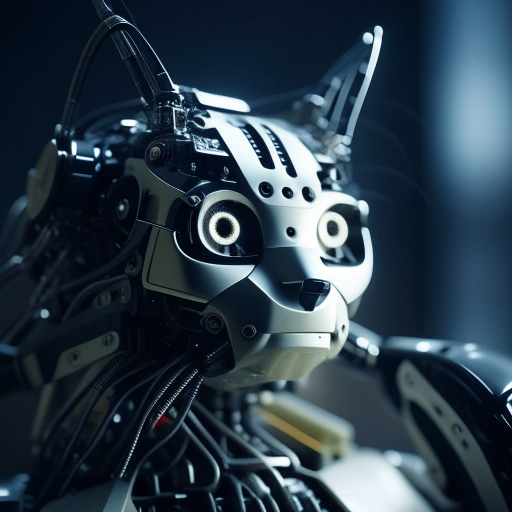

In [ ]:
images.images[0]

In [ ]:
!nvidia-smi

Tue Jul  4 00:27:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |  12411MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------